# Solve utility-scale quantum optimization problems

*Estimated QPU usage: 8 minutes (tested on IBM Sherbrooke)*

This tutorial demonstrates how to implement the **Quantum Approximate Optimization Algorithm (QAOA)** – a hybrid (quantum-classical) iterative method – within the context of Qiskit patterns. You will first solve the **Maximum-Cut** (or **Max-Cut**) problem for a small graph and then learn how to execute it at utility scale. All the hardware executions in the notebook should run within the time limit for the freely-accessible Open Plan.

The Max-Cut problem is an optimization problem that is hard to solve (more specifically, it is an *NP-hard* problem) with a number of different applications in clustering, network science, and statistical physics. This tutorial considers a graph of nodes connected by vertices, and aims to partition it into separate graphs such that they are both as large as possible. Put another way, the goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized.

![Illustration of a max-cut problem](https://learning-api.quantum.ibm.com/assets/0de75f52-4873-4b5a-a0e9-a351dc48c910)


## Requirements

Before starting this tutorial, be sure you have the following installed:

* Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* Rustworkx graph library (`pip install rustworkx`)


In [1]:
!pip install 'qiskit[visualization]'
!pip install qiskit-ibm-runtime
!pip install rustworkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=06d778395bdbacadd312897a9387570a17496f54d04859a1227bbb191f15a971
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

## Part 1: Small-scale QAOA

The first part of this tutorial uses a small-scale Max-Cut problem to illustrate the steps to solve an optimization problem using a quantum computer.

To give some context before mapping this problem to a quantum algorithm, you can better understand how the Max-Cut problem becomes a classical combinatorial optimization problem by first considering the minimization of a function $f(x)$

$$
\min_{x\in \{0, 1\}^n}f(x),
$$

where the input $x$ is a vector whose components correspond to each node of a graph.  Then, constrain each of these components to be either $0$ or $1$ (which represent being included or not included in the cut). This small-scale example case uses a graph with $n=5$ nodes.

You could write a function of a pair of nodes $i,j$ which indicates whether the corresponding edge $(i,j)$ is in the cut. For example, the function $x_i + x_j - 2 x_i x_j$ is 1 only if one of either $x_i$ or $x_j$ are 1 (which means that the edge is in the cut) and zero otherwise. The problem of maximizing the edges in the cut can be formulated as

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
$$

which can be rewritten as a minimization of the form

$$
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
$$

The minimum of $f(x)$ in this case is when the number of edges traversed by the cut is maximal. As you can see, there is nothing relating to quantum computing yet. You need to reformulate this problem into something that a quantum computer can understand.


Initialize your problem by creating a graph with $n=5$ nodes.


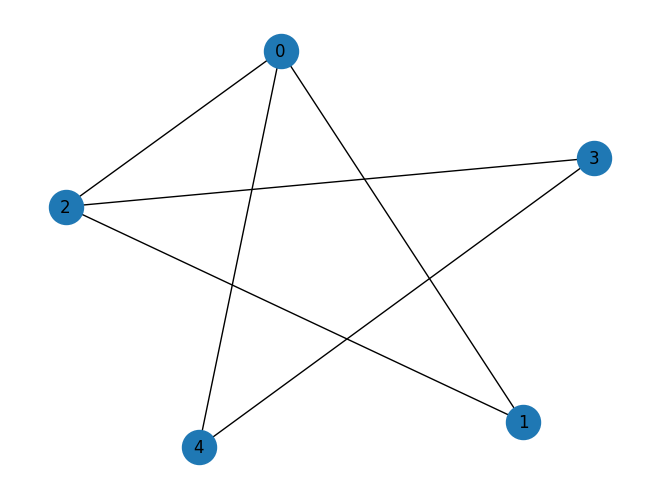

In [95]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

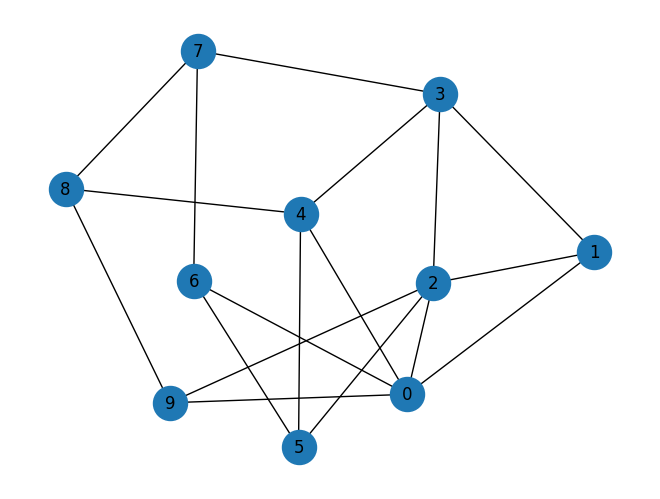

In [37]:
# n=10
n = 10

# Create a graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))

# Define a more complex edge list
edge_list = [
    (0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (1, 3, 1.0),
    (2, 3, 1.0), (2, 5, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0),
    (6, 7, 1.0), (7, 8, 1.0), (8, 9, 1.0), (9, 0, 1.0), (3, 7, 1.0),
    (4, 8, 1.0), (2, 9, 1.0), (6, 0, 1.0)
]
graph.add_edges_from(edge_list)

# Draw the graph
draw_graph(graph, node_size=600, with_labels=True)

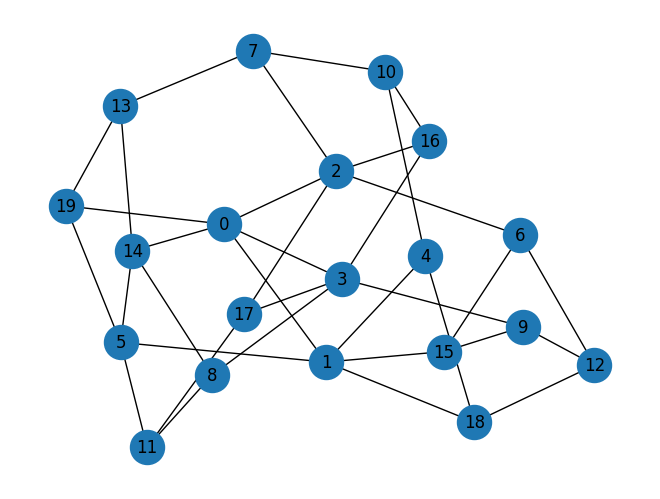

In [57]:
n = 20

# Create a graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))

# Define a more complex edge list for 20 nodes
edge_list = [
    (0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0),
    (2, 6, 1.0), (2, 7, 1.0), (3, 8, 1.0), (3, 9, 1.0), (4, 10, 1.0),
    (5, 11, 1.0), (6, 12, 1.0), (7, 13, 1.0), (8, 14, 1.0), (9, 15, 1.0),
    (10, 16, 1.0), (11, 17, 1.0), (12, 18, 1.0), (13, 19, 1.0), (14, 0, 1.0),
    (15, 1, 1.0), (16, 2, 1.0), (17, 3, 1.0), (18, 4, 1.0), (19, 5, 1.0),
    (6, 15, 1.0), (7, 10, 1.0), (8, 11, 1.0), (9, 12, 1.0), (13, 14, 1.0),
    (0, 19, 1.0), (5, 14, 1.0), (3, 16, 1.0), (2, 17, 1.0), (1, 18, 1.0)
]
graph.add_edges_from(edge_list)

# Draw the graph
draw_graph(graph, node_size=600, with_labels=True)

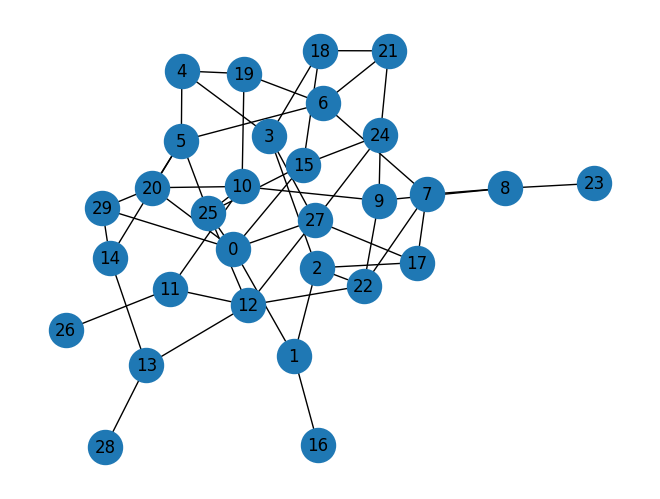

In [108]:
n = 30

# Create a graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))

# Define a complex edge list for 30 nodes
edge_list = [
    # Local connections
    (0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0),
    (5, 6, 1.0), (6, 7, 1.0), (7, 8, 1.0), (8, 9, 1.0), (9, 10, 1.0),
    (10, 11, 1.0), (11, 12, 1.0), (12, 13, 1.0), (13, 14, 1.0),

    # Cross-links for complexity
    (0, 15, 1.0), (1, 16, 1.0), (2, 17, 1.0), (3, 18, 1.0), (4, 19, 1.0),
    (5, 20, 1.0), (6, 21, 1.0), (7, 22, 1.0), (8, 23, 1.0), (9, 24, 1.0),
    (10, 25, 1.0), (11, 26, 1.0), (12, 27, 1.0), (13, 28, 1.0), (14, 29, 1.0),

    # Adding cycles
    (0, 29, 1.0), (5, 25, 1.0), (10, 20, 1.0), (15, 25, 1.0), (20, 0, 1.0),

    # Long-distance connections
    (3, 27, 1.0), (6, 19, 1.0), (9, 22, 1.0), (12, 25, 1.0), (15, 18, 1.0),
    (18, 21, 1.0), (21, 24, 1.0), (24, 27, 1.0), (27, 0, 1.0),

    # Extra complexity
    (5, 14, 1.0), (10, 19, 1.0), (15, 24, 1.0), (20, 29, 1.0), (25, 0, 1.0),
    (7, 17, 1.0), (12, 22, 1.0), (17, 27, 1.0), (22, 2, 1.0)
]
graph.add_edges_from(edge_list)

# Draw the graph
draw_graph(graph, node_size=600, with_labels=True)

### Classic Algorithms for comparison

In [109]:
import rustworkx as rx
import networkx as nx

def rustworkx_to_networkx(rustworkx_graph):
    # 创建一个空的 networkx 图
    networkx_graph = nx.Graph()

    # 添加节点
    networkx_graph.add_nodes_from(rustworkx_graph.node_indices())

    # 添加边并带上权重
    for u, v, weight in rustworkx_graph.weighted_edge_list():
        networkx_graph.add_edge(u, v, weight=weight)

    return networkx_graph

In [110]:
# Brute-force algorithm
from itertools import product

def calculate_cut(graph, partition):
    """Calculate the cut size for a given partition of nodes."""
    cut_size = 0
    for u, v, _ in graph.weighted_edge_list():
        if partition[u] != partition[v]:  # Nodes are in different sets
            cut_size += 1
    return cut_size

def max_cut_brute_force(graph):
    n = len(graph.nodes())
    max_cut = 0

    # Iterate over all possible binary partitions of n nodes
    for bits in product([0, 1], repeat=n):
        # bits[i] == 0 means node i is in set A, bits[i] == 1 means node i is in set B
        cut_size = calculate_cut(graph, bits)
        max_cut = max(max_cut, cut_size)

    return max_cut

In [111]:
%%time
# max_cut_value = max_cut_brute_force(graph)
# print("brute-force result:", max_cut_value)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [112]:
# https://github.com/pandrey-fr/maxcut/blob/master/maxcut/_graphs.py

def load_gset_graph(path):
    """Create a networkx.graph based on a Gset graph file.

    Gset is a collection of graphs used in by Burer and Monteiro
    in papers from 2003 and 2005, available for download at
    https://web.stanford.edu/~yyye/yyye/Gset.
    """
    graph = nx.Graph()
    with open(path) as file:
        n_nodes = int(file.readline().split(' ', 1)[0])
        graph.add_nodes_from(range(n_nodes))
        for row in file:
            start, end, weight = [int(e) for e in row.strip('\n').split()]
            graph.add_edge(start - 1, end - 1, weight=weight)
    return graph


def generate_sbm(sizes, probs, maxweight=1):
    """Generate a Stochastic Block Model graph.

    Assign random values drawn from U({1, ...,  maxw}) to the edges.

    sizes     : list of sizes (int) of the blocks
    probs     : matrix of probabilities (in [0, 1]) of edge creation
                between nodes depending on the blocks they belong to
    maxweight : maximum value of the weights to randomly assign
                (default 1, resulting in weights all equal to 1)
    """
    graph = nx.stochastic_block_model(sizes, probs)
    weights = 1 + np.random.choice(maxweight, len(graph.edges))
    weights = dict(zip(graph.edges, weights))
    nx.set_edge_attributes(graph, weights, 'weight')
    return graph

In [113]:
# https://github.com/pandrey-fr/maxcut/blob/master/maxcut/riemannian/stiefel/_stiefel.py

"""Collection of operations relative to St(1, p)^n Stiefel manifolds.

A Stiefel manifold St(n, p) is a riemannian manifold defined
as the ensemble of matrices of dimensions (n, p) so that all
$X$ in St(n, p) verify $X^\\top X = I_p$.

Here, the operations concern a more specific and less constraining
case, based on [Boumal, 2016]. We denote by St(1, p)^n the ensemble
of matrices whose columns belong to a St(1, p) manifold; hence we
have $diag(Y Y^\\top) = 1_{{R^n}}$ for any $Y \\in St(1, p)^n.$

Reference:
N. Boumal (2016). A Riemannian low-rank method for optimization
oversemidefinite matrices with block-diagonal constraints.
arXiv preprint.
"""



def inner_prod(mat_x, mat_y):
    """Compute the inner product between two matrices.

    $<X, Y> := Tr(X^\\top Y)$ with $X$ and $Y$ two matrices with
    the same dimensions. This inner product is notably that used
    on Stiefel manifolds.
    """
    return np.trace(np.dot(mat_x.T, mat_y))


def froebenius(matrix):
    """Compute the Froebenius norm of a matrix.

    $$||X||_F := \\sqrt{{Tr(X^\\top X)}}$$
    is notably the norm used on Stiefel manifolds.
    """
    return np.sqrt(np.trace(np.dot(matrix.T, matrix)))


def random_from_stiefel(dim_n, dim_p):
    """Generate a random matrix from the St(1, p)^n manifold."""
    matrix = np.random.normal(size=(dim_n, dim_p))
    norm = np.sqrt(np.sum(np.square(matrix), axis=1))
    return matrix / np.expand_dims(norm, 1)


def stiefel_dimension(dim_n, dim_p):
    """Return the dimension of a Stiefel manifold St(1, p)^n.

    in general, dim St(d, p)^m = mdp - .5 * md(d + 1)
    hence here, dim St(1, p)^n = np - n = n(p - 1)
    """
    return dim_n * (dim_p - 1)


def stiefel_projection(pointmat, matrix):
    """Project orthogonally a matrix on the tangent space at a point.

    This projection is defined for matrices in a St(1, p)^n manifold.

    pointmat : matrix at which the tangent space is defined
    matrix   : matrix to project on the tangent space
    """
    sym = symblockdiag(np.dot(matrix, pointmat.T))
    return matrix - np.dot(sym, pointmat)


def stiefel_retraction(pointmat, matrix):
    """Retract a matrix from a tangent space to the manifold.

    This retraction is defined for matrices in a St(1, p)^n manifold.

    pointmat : matrix at which the tangent space is defined
    matrix   : matrix to retract from the tangent space
    """
    def retract_row(row):
        svd = np.linalg.svd(np.expand_dims(row, 0), full_matrices=False)
        return np.dot(svd[0], svd[2])
    return np.concatenate([retract_row(row) for row in pointmat + matrix])


def symblockdiag(matrix):
    """Extract the diagonal of a matrix, setting over values to zero.

    This is a specific case of the symblockdiag transformation
    defined in [Boumal, 2016] for matrices that belong to a St(1, p)^n
    manifold (instead of a more general St(d, p)^m one).
    """
    return np.diag(np.diag(matrix))

In [114]:
class RiemannianTrustRegion:
    """Riemannian trust-region algorithm to solve SDP problems.

    The Riemannian trust-regions method implemented here is meant
    to find a minimizer of $$<CY, Y>$$ where $C$ is a given matrix
    of dimensions $(n, n)$ and $Y \\in St(1, n)^p$, i.e. $Y$
    is a matrix of dim $(n, p)$ so that $diag(Y Y^\\top) = 1_{{R^n}}$.
    In this context, $<X, Y> = Tr(X^\\top Y)$.

    This problem is a non-convex relaxation of the Semi-Definite
    Programming problem of minimizing $<C, X>$ where $X$ is PSD
    and all elements of its diagonal are 1, by rewriting $X$ as
    $Y Y^\\top$ with the only constraint that $Y \\in St(1, n)^p$.

    Above, we denote by $St(d, p)^n$ an extension of the usual
    Stiefel manifold to matrices made of p blocks which belong
    to a $St(d, p)$ manifold. Here, since d=1, it simply means
    that the p columns of the matrices belong to a $St(1, p)$
    manifold, hence yielding the aforementionned constraint on
    its diagonal. (see [Boumal, 2016])

    The algorithm and the notations are based on [Algorithm 10]
    presented in [Absil et al. 2008] (see full reference below),
    while default parameters and implementation are partly based
    on the RTR Matlab implementation from the Manopt toolbox
    (see [Boumal et al. 2014] and link to source code below).

    Usage:
    >>> rtr = RiemannianTrustRegion(cost_mat, dim_p)
    >>> minimizer = rtr.get_solution()

    References:
    P.-A. Absil, R. Mahony, and R. Sepulchre (2008). Optimization
    Algorithms on Matrix Manifolds. Princeton University Press.

    N. Boumal (2016). A Riemannian low-rank method for optimization
    oversemidefinite matrices with block-diagonal constraints.
    arXiv preprint.

    N. Boumal, B. Mishra, P.-A. Absil and R. Sepulchre (2014).
    Manopt, a Matlab toolbox for optimization on manifolds.
    Journal of Machine Learning Research.
    source code at https://github.com/NicolasBoumal/manopt
    """

    def __init__(
            self, cost_mat, dim_p, rho_prime=.1, maxiter=10000, **kwargs
        ):
        """Instantiate the RTR solver, setting the problem.

        The problem to solve is $min <CY, Y>$ for a given square
        matrix $C$ of dimension n*n, with $Y \\in St(1, p)^n$
        i.e. $Y$ a matrix of dimensions n*p so that $Y Y^\\top$
        has only values equal to 1 on its diagonal.

        problem-defining arguments
        --------------------------
        cost_mat  : square matrix defining the cost function
        dim_p     : dimension p of the St(1, n)^p manifold
                    on which to look for a minimizer

        method-adjusting arguments
        --------------------------
        rho_prime : minimum value of ratio rho at step k
                    to update the value of the candidate
        maxiter   : maximum number of RTR iterations
        **kwargs  : keyword arguments to pass to the trust-region
                    subproblem solvers, in {{'theta', 'kappa'}}.
                    (see TruncatedConjugateGradient for details)

        See [Absil et al. 2008] for details on the algorithm.
        Some parameters, such as the mean and starting radius
        of the trust-regions in which to look for an optimum,
        are set according to the default values used in the
        Matlab implementation of the algorithm in the Manopt
        toolbox (see [Boumal et al. 2014]).
        """
        self.cost_mat = cost_mat
        self.dimensions = (len(cost_mat), dim_p)
        # Set up method parameters.
        self.rho_prime = min(rho_prime, .25)
        self.maxiter = maxiter
        # Set up deltabar and the max number of tCG iterations
        # based on the dimension of the Stiefel manifold.
        self.deltabar = np.sqrt(np.prod(self.dimensions))
        kwargs['maxiter'] = stiefel_dimension(*self.dimensions)
        self.tcg_kwargs = kwargs
        # Set up a private attribute to store the solutions.
        self.__candidates = []

    def get_candidates(self, verbose=False):
        """Return the lazy-evaluated candidates reached by the RTR method."""
        if not self.__candidates:
            self.solve(verbose)
        return self.__candidates

    def solve(self, verbose=True):
        """Run the RTR algorithm to find candidate minimizers."""
        # Set up the initial trust-regions radius (follow manopt default).
        delta = self.deltabar / 8  # default value in manopt implementation
        # Pick a random value x_0 and compute f values on it.
        x_k = random_from_stiefel(*self.dimensions)
        value, gradient, get_hessian = self._get_f_values(x_k)
        # Iteratively solve and adjust trust-region subproblems.
        n_iter = 0
        stop_cause = 'maximum number of iterations reached'
        for n_iter in range(self.maxiter):
            # Solve the trust-region subproblem.
            eta_k, rho_k, x_new = self._solve_tr_subproblem(
                x_k, value, gradient, get_hessian, delta
            )
            # Update the radius of the trust region (delta), if relevant.
            if rho_k < .25:
                delta *= .25
            elif rho_k > .75 and round(froebenius(eta_k), 2) == delta:
                delta = min(2 * delta, self.deltabar)
            # Adopt the new candidate solution, if relevant.
            if rho_k > self.rho_prime:
                value_new, gradient, get_hessian = self._get_f_values(x_new)
                x_k, value = x_new, value_new
                self.__candidates.append(x_k)
                # Check a stopping criterion on the gradient's norm.
                if froebenius(gradient) < 1e-6:
                    stop_cause = "vanishing gradient"
                    break
        # Optionally print-out stopping cause.
        if verbose:
            print(stop_cause)
            print(
                "%i candidate solutions reached after %i iterations.\n"
                % (len(self.__candidates), n_iter)
            )

    def _get_f_values(self, matrix):
        """Return f(matrix), grad f(matrix) and Hess f(matrix)[.].

        The values of f and of its riemannian gradient are explicitely
        computed, while a function is built to compute the riemannian
        hessian in any given direction.
        """
        # Compute the value of f.
        matprod = np.dot(matrix, matrix.T)
        value = inner_prod(self.cost_mat, matprod)
        # Compute the value of grad f.
        gradient = np.dot(self.cost_mat, matrix)
        gradient = 2 * stiefel_projection(matrix, gradient)
        # Define a function to compute the value of Hess f in a direction.
        sym = symblockdiag(np.dot(self.cost_mat, matprod))
        def get_hessian(direction):
            """Get the riemannian hessian of f in a given direction."""
            nonlocal self, sym, matrix
            hess = np.dot(self.cost_mat, direction) - np.dot(sym, direction)
            return 2 * stiefel_projection(matrix, hess)
        # Return f(x_k), grad f(x_k) and function to get Hess f(x_k)[d].
        return value, gradient, get_hessian

    def _solve_tr_subproblem(self, x_k, value, gradient, get_hessian, delta):
        """Solve the trust-region subproblem and return derived quantities.

        x_k         : current candidate optimum x_k
        value       : value of f(x_k)
        gradient    : value of grad f(x_k)
        get_hessian : function to get Hess f(x_k) [.]
        delta       : radius of the trust-region

        The trust-region subproblem consists in minimizing the quantity
        $m(\\eta) = f(x_k) + <\\text{{grad}} f(x_k), eta>
                    + .5 <\\text{{Hess}} f(x_k)[eta], eta>$
        under the constraint $||\\eta|| = \\Delta$.

        First, estimate eta_k using the truncated conjugate gradient
        method, and gather the value of the cost function in eta_k.

        Then, compute the retraction of eta_k from the tangent space
        in x_k; this retraction is a candidate for $x_{{k+1}}$.

        Finally, compute the ratio rho_k used to accept of reject
        the previous candidate and update the radius delta:
        $\\rho_k = (f(x_k) - f(R_x(\\eta_k))) / (m(0) - m(\\eta_k))$.

        Return eta_k, rho_k and R_x(eta_k) (candidate eta_{{k+1}}).
        """
        # Arguments serve readability; pylint: disable=too-many-arguments
        # Solve the trust-region subproblem.
        tcg = TruncatedConjugateGradient(
            value, gradient, get_hessian, delta, **self.tcg_kwargs
        )
        eta_k, cost_eta = tcg.get_solution()
        # Compute the retraction of the solution.
        rx_k = stiefel_retraction(x_k, eta_k)
        # Compute the ratio rho_k.
        f_rxk = inner_prod(self.cost_mat, np.dot(rx_k, rx_k.T))
        rho_k = (value - f_rxk) / (value - cost_eta + 1e-30)
        # Return eta_k, rho_k and the potential new optimum candidate.
        return eta_k, rho_k, rx_k


class TruncatedConjugateGradient:
    """Truncated Conjugate Gradient for the Trust-Region subproblem.

    The truncated Conjugate-Gradient method implemented here
    is meant to approximate the solution of the trust-region
    subproblem, i.e. minimizing the following quadratic form
    $$f(x_k) + <\\text{{grad}}f(x_k), \\eta> + .5 <H_k[\\eta, \\eta]>$$
    in $\\eta$ subject to $||eta|| \\leq \\Delta$, where $f$, its
    riemannian gradient and riemannian hessian (used as $$H$$)
    are pre-computed, $\\Delta$ is given and the scalar product
    and norm are implemented (outside from this class) as (resp.)
    $<X, Y> = Tr(X^\\top Y)$ and the Froebenius norm.

    The algorithm and the notations are based on [Algorithm 11]
    presented in [Absil et al. 2008] (see full reference below),
    while default parameters and implementation are partly based
    on the tCG Matlab implementation from the Manopt toolbox
    (see [Boumal et al. 2014] and link to source code below).

    The truncation of the gradient descent is designed using
    the following stopping criterion :
    $$||r_{{j+1}}|| \\leq ||r_0|| \\min(||r_0||^\\theta, \\kappa)$$
    where $r_j$ is a residual at step $j$ with $r_0$ equal to
    $\\text{{grad}}f(x_k)$, and $\\theta and \\kappa$ are given
    parameters. This criterion guarantees superlinear convergence
    (see equation [7.10] from [Absil et al. 2008]).

    Usage:
    >>> tcg = TruncatedConjugateGradient(value, gradient, get_hess, radius)
    >>> minimizer, min_cost = tcg.get_solution()

    References:
    P.-A. Absil, R. Mahony, and R. Sepulchre (2008). Optimization
    Algorithms on Matrix Manifolds. Princeton University Press.

    N. Boumal, B. Mishra, P.-A. Absil and R. Sepulchre (2014).
    Manopt, a Matlab toolbox for optimization on manifolds.
    Journal of Machine Learning Research.
    source code at https://github.com/NicolasBoumal/manopt
    """

    # Attrib. serve readability; pylint: disable=too-many-instance-attributes
    def __init__(
            self, value, gradient, get_hess, radius,
            theta=1, kappa=.1, maxiter=10000
        ):
        """Instantiate the tCG solver, setting the problem's quantities.

        problem-defining arguments
        --------------------------
        value    : value of f in x_k
        gradient : riemannian gradient of f in x_k
        get_hess : function to compute the riemannian hessian
                   of f(x_k) in a given direction
        radius   : constraint value of the norm of the solution

        method-adjusting arguments
        --------------------------
        theta    : value of theta in the stopping criterion
        kappa    : value of kappa in the stopping criterion
        maxiter  : maximum number of iterations
        """
        # Arguments serve modularity; pylint: disable=too-many-arguments
        # Assign the problem's quantities as attributes.
        self.value = value
        self.gradient = gradient
        self.get_hessian = get_hess
        self.radius = radius
        # Set up the stopping criterion.
        bound = froebenius(gradient)
        self.stopping_criterion = (bound * min(bound ** theta, kappa)) ** 2
        self.maxiter = maxiter
        # Set up private solution attributes.
        self.__solution = None
        self.__cost = np.inf

    def get_solution(self, verbose=False):
        """Return the lazy-evaluated solution reached by the tCG method.

        Return both the estimated minimizer of the cost function
        and the value of the latter in that point.
        """
        if self.__solution is None:
            self.solve(verbose)
        return self.__solution, self.__cost

    def solve(self, verbose=True):
        """Solve the trust region subproblem using the tCG method."""
        # Refactoring is hard here; pylint: disable=too-many-locals
        # Initialize quantities used in solving the TR subproblem.
        eta, delta, resid, r_norm = self._initialize_solver()
        self.__cost = self.value
        stop_cause = 'maximum number of iterations reached'
        # Iteratively update eta until convergence (or stop).
        n_iter = 0
        for n_iter in range(self.maxiter):
            # Compute <delta, Hess f[delta]> and thus update factor alpha.
            hess_delta = self.get_hessian(delta)
            dh_norm = inner_prod(delta, hess_delta)
            alpha = r_norm / dh_norm
            # Compute candidate eta_new and approximate Hess f [eta_new].
            eta_new = eta + alpha * delta
            # If <delta, Hess f[delta]>  <= 0 or ||eta_{k+1}|| >= Delta,
            # compute an update of eta of proper norm and stop iterating.
            if (dh_norm <= 0) or (froebenius(eta_new) >= self.radius):
                eta = self._fit_eta_tau(eta, delta)
                stop_cause = 'radius condition -- computed fitted-norm eta'
                break
            # Check that the cost decreases with eta_new, otherwise stop.
            new_cost = self._get_model_cost(eta_new)
            if new_cost >= self.__cost:
                stop_cause = 'increased cost -- adopted previous solution'
                break
            self.__cost = new_cost
            # Update the residuals and check the stopping criterion.
            resid += alpha * hess_delta
            rnorm_new = inner_prod(resid, resid)
            if rnorm_new <= self.stopping_criterion:
                stop_cause = 'stopping criterion reached'
                break
            # In the absence of solution, update quantities and iterate.
            delta = - resid + delta * rnorm_new / r_norm
            eta, r_norm = eta_new, rnorm_new
        # Store the solution reached as well as the cost function on it.
        self.__solution = eta
        self.__cost = self._get_model_cost(eta)
        # Print-out the number of iterations needed to converge.
        if verbose:
            print("Solution reached afer %i iterations." % n_iter)
            print(stop_cause)

    def _initialize_solver(self):
        """Set up and return the initial quantities used by the solver."""
        eta = np.zeros_like(self.gradient)
        delta = - self.gradient
        resid = self.gradient
        r_norm = inner_prod(resid, resid)
        return eta, delta, resid, r_norm

    def _get_model_cost(self, eta):
        """Return the cost function's value, given eta and Hessf[eta]."""
        return (
            self.value + inner_prod(self.gradient, eta)
            + .5 * inner_prod(self.get_hessian(eta), eta)
        )

    def _fit_eta_tau(self, eta, delta):
        """Compute the problem's solution in a specific case.

        Given eta and delta at a given iteration, compute tau
        so that $||\\eta_j + \\tau \\delta_j|| = \\Delta$ and
        return the resulting eta of norm Delta (self.radius).

        This problem can be rewritten as an order-2 polynom
        in tau whose discriminant is strictly positive.
        A positive root is thus computed explicitely.
        """
        coeff_a = np.sum(np.square(delta))
        coeff_b = 2 * np.sum(eta * delta)
        coeff_c = np.sum(np.square(eta)) - (self.radius ** 2)
        discrim = (coeff_b ** 2) - (4 * coeff_a * coeff_c)
        tau = .5 * (np.sqrt(discrim) - coeff_b) / coeff_a
        return eta + tau * delta

In [115]:
# https://github.com/pandrey-fr/maxcut/blob/master/maxcut/_solvers/backend.py

"""Backend class and functions for max-cut solvers."""

from abc import ABCMeta, abstractmethod



class AbstractMaxCut(metaclass=ABCMeta):
    """Abstract class for Max-Cut problem solvers."""

    def __init__(self, graph):
        """Instantiate the solver."""
        self.graph = graph
        self._results = None

    def get_results(self, item='cut', verbose=False):
        """Return the lazy-evaluated max-cut results reached.

        item : whether to return the 'cut' itself, its 'value'
               or the initial 'matrix' solving the SDP program
        """
        if self._results is None:
            self.solve(verbose)
        if item not in self._results:
            valid = ', '.join(["'%s'" % key for key in self._results.keys()])
            raise KeyError(
                "In valid 'item' keyword: should be one of {{%s}}." % valid
            )
        return self._results.get(item)

    @abstractmethod
    def solve(self, verbose=True):
        """Solve the BM-formulated max-cut problem using RTR.

        Resulting cut, value of the cut and solved matrix
        may be accessed through the `get_solution` method.
        """
        return NotImplemented


def get_partition(vectors):
    """Cut a graph based on a matricial solution using randomized rounding.

    vectors   : matrix of vectors of unit norm (as rows),
                defining the cut probabilities to round up

    Use the Goemans-Williamson rounding technique, deciding which
    set to assign each node depending on the sign of the dot product
    between said node's vector and a random unit-norm one.

    Return a list of {{-1, +1}} values indicating to which part
    each node belongs.
    """
    # Pick a random vector on the unit sphere.
    random = np.random.normal(size=vectors.shape[1])
    random /= np.linalg.norm(random, 2)
    # Compute partition probabilities and round the cut.
    return np.sign(np.dot(vectors, random))


def get_cut_value(graph, partition):
    """Compute the share of edges' weights in a given cut.

    graph     : graph being cut off
    partition : list of {{-1, +1}} values indicating
                to which part each node belongs
    """
    in_cut = sum(
        attr['weight'] for u, v, attr in graph.edges(data=True)
        if partition[u] != partition[v]
    )
    total = .5 * nx.adjacency_matrix(graph).sum()
    return in_cut / total

In [116]:
# https://github.com/pandrey-fr/maxcut/blob/master/maxcut/_solvers/_bm.py

"""Bureir-Monteiro approach solver for the Max-Cut problem."""


class MaxCutBM(AbstractMaxCut):
    """Bureir-Monteiro approach solver for the Max-Cut problem.

    Given a graph with non-negative weights, the method implemented
    here aims at minimizing $$<CY, Y>$$, where C denotes the adjacency
    matrix of the graph and $Y$ is a matrix of dimensions (n, p) so
    that each of its rows is of unit norm.

    The implementation relies on a Riemannian Trust-Region algorithm,
    which itself relies on a truncated conjugate gradient method to
    iteratively solve and adjust trust-region subproblems in order
    to converge towards a global minimizer.

    Usage:
    >>> bm = MaxCutBM(graph)
    >>> cut = bm.get_solution('cut')          # solve problem here
    >>> cut_value = bm.get_solution('value')  # get pre-computed solution

    See the documentation of classes RiemannianTrustRegion and
    TruncatedConjugateGradient for more details and references.
    """

    def __init__(self, graph, dim_p=None, **kwargs):
        """Instantiate the Bureir-Monteiro Max-Cut solver.

        graph    : networkx.Graph instance of the graph to cut
        dim_p    : optional value of p; otherwise, use
                   ceil(sqrt(2 * n_nodes))
        **kwargs : any keyword argument for RiemannianTrustRegion
                   may additionally be passed (e.g. maxiter)
        """
        # Declare the graph attribute and the __results backend one.
        super().__init__(graph)
        # Set up the dimension of the search space.
        if dim_p is None:
            dim_p = np.ceil(np.sqrt(2 * len(graph)))
        self.dim_p = int(dim_p)
        # Store arguments to pass on to the RiemannianTrustRegion solver.
        self._kwargs = kwargs

    def solve(self, verbose=True):
        """Solve the BM-formulated max-cut problem using RTR.

        Resulting cut, value of the cut and solved matrix
        may be accessed through the `get_solution` method.
        """
        # Run the RTR algorithm and gather candidate solutions.
        adjacent = nx.adjacency_matrix(self.graph).toarray()
        rtr = RiemannianTrustRegion(adjacent, self.dim_p, **self._kwargs)
        candidates = rtr.get_candidates(verbose)
        # Find and keep the best candidate.
        matrix, cut, value = self._get_best_candidate(candidates)
        self._results = {'matrix': matrix, 'cut': cut, 'value': value}
        # Optionally be verbose about the results.
        if verbose:
            print(
                "Solved the BM-formulated max-cut problem.\n"
                "Solution cuts off %f share of total weights." % value
            )

    def _get_best_candidate(self, candidates):
        """Select the best solution among a series of candidates.

        Return both the matrix, derived partition and value of
        the latter associated with the best candidate (in terms
        of sum of weights of the edges cut off).
        """
        # Get the partition defined by each candidate and their cut-value.
        partitions = [get_partition(vectors) for vectors in candidates]
        scores = [get_cut_value(self.graph, cut) for cut in partitions]
        # Select the best candidate and return it.
        best = np.argmax([scores])
        return candidates[best], partitions[best], scores[best]

In [117]:
# https://github.com/pandrey-fr/maxcut/blob/master/maxcut/_solvers/_sdp.py

"""Semi-Definite Programming based solver for the Max-Cut problem."""

import cvxpy as cp
# import networkx as nx
# import numpy as np

# from maxcut._solvers.backend import (
#     AbstractMaxCut, get_partition, get_cut_value
# )


class MaxCutSDP(AbstractMaxCut):
    """Semi-Definite Programming based solver for the Max-Cut problem.

    Given a graph with non-negative weights, the method implemented
    here aims at maximizing $$\\sum_{{i < j}} w_{{ij}}(1 - x_{{ij}})$$
    where $X = (x_{{ij}}))$ is a positive semi-definite matrix with
    values equal to 1 on its diagonal.

    The implementation relies on an external solver, interfaced
    through the `cvxpy` package, thus allowing the user to select
    the precise solver to use (by default, 'scs').

    Usage:
    >>> sdp = MaxCutSDP(graph)
    >>> cut = sdp.get_solution('cut')          # solve problem here
    >>> cut_value = sdp.get_solution('value')  # get pre-computed solution
    """

    def __init__(self, graph, solver='scs'):
        """Instantiate the SDP-relaxed Max-Cut solver.

        graph  : networkx.Graph instance of the graph to cut
        solver : name of the solver to use (default 'scs')

        Note:
        'cvxopt' appears, in general, better than 'scs', but tends
        to disfunction on large (or even middle-sized) graphs, for
        an unknown reason internal to it. 'scs' is thus preferred
        as default solver.
        """
        # Declare the graph attribute and the __results backend one.
        super().__init__(graph)
        # Check that the required solver is available through cvxpy.
        solver = solver.upper()
        if solver not in cp.installed_solvers():
            raise KeyError("Solver '%s' is not installed." % solver)
        self.solver = getattr(cp, solver)

    def solve(self, verbose=True):
        """Solve the SDP-relaxed max-cut problem.

        Resulting cut, value of the cut and solved matrix
        may be accessed through the `get_solution` method.
        """
        # Solve the program. Marginally adjust the matrix to be PSD if needed.
        matrix = self._solve_sdp()
        matrix = nearest_psd(matrix)
        # Get the cut defined by the matrix.
        vectors = np.linalg.cholesky(matrix)
        cut = get_partition(vectors)
        # Get the value of the cut. Store results.
        value = get_cut_value(self.graph, cut)
        self._results = {'matrix': matrix, 'cut': cut, 'value': value}
        # Optionally be verbose about the results.
        if verbose:
            print(
                "Solved the SDP-relaxed max-cut problem.\n"
                "Solution cuts off %f share of total weights." % value
            )

    def _solve_sdp(self):
        """Solve the SDP-relaxed max-cut problem.

        Return the matrix maximizing <C, 1 - X>
        """
        # Gather properties of the graph to cut.
        n_nodes = len(self.graph)
        adjacent = nx.adjacency_matrix(self.graph).toarray()
        # Set up the semi-definite program.
        matrix = cp.Variable((n_nodes, n_nodes), PSD=True)
        cut = .25 * cp.sum(cp.multiply(adjacent, 1 - matrix))
        problem = cp.Problem(cp.Maximize(cut), [cp.diag(matrix) == 1])
        # Solve the program.
        problem.solve(getattr(cp, self.solver))
        return matrix.value


def nearest_psd(matrix):
    """Find the nearest positive-definite matrix to input.

    Numpy can be troublesome with rounding values and stating
    a matrix is PSD. This function is thus used to enable the
    decomposition of result matrices

    (altered code from) source:
    https://gist.github.com/fasiha/fdb5cec2054e6f1c6ae35476045a0bbd
    """
    if is_psd(matrix):
        return matrix
    # false positive warning; pylint: disable=assignment-from-no-return
    spacing = np.spacing(np.linalg.norm(matrix))
    identity = np.identity(len(matrix))
    k = 1
    while not is_psd(matrix):
        min_eig = np.min(np.real(np.linalg.eigvals(matrix)))
        matrix += identity * (- min_eig * (k ** 2) + spacing)
        k += 1
    return matrix


def is_psd(matrix):
    """Check whether a given matrix is PSD to numpy."""
    try:
        _ = np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

In [118]:
%%time
graphnx = rustworkx_to_networkx(graph)
max_cut = MaxCutBM(graphnx)
print("MaxCutBM result:", max_cut.solve())

maximum number of iterations reached
3 candidate solutions reached after 9999 iterations.

Solved the BM-formulated max-cut problem.
Solution cuts off 0.788462 share of total weights.
MaxCutBM result: None
CPU times: user 10.7 s, sys: 57.6 ms, total: 10.7 s
Wall time: 11 s


In [119]:
%%time
graphnx = rustworkx_to_networkx(graph)
max_cut = MaxCutSDP(graphnx)
print("MaxCutSDP result:", max_cut.solve())

Solved the SDP-relaxed max-cut problem.
Solution cuts off 0.807692 share of total weights.
MaxCutSDP result: None
CPU times: user 48.7 ms, sys: 997 µs, total: 49.7 ms
Wall time: 51.6 ms


### Step 1. Map classical inputs to a quantum problem

The first step of the pattern is to map the classical problem (graph) into quantum **circuits** and **operators**. To do this, there are three main steps to take:

1. Utilize a series of mathematical reformulations, to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.
2. Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function.
3. Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.

**Note:** In the QAOA methodology, you ultimately want to have an operator (**Hamiltonian**) that represents the **cost function** of our hybrid algorithm, as well as a parametrized circuit (**Ansatz**) that represents quantum states with candidate solutions to the problem. You can sample from these candidate states and then evaluate them using the cost function.

#### Graph → optimization problem

The first step of the mapping is a notation change, The following expresses the problem in QUBO notation:

$$
\min_{x\in \{0, 1\}^n}x^T Q x,
$$

where $Q$ is a $n\times n$ matrix of real numbers, $n$ corresponds to the number of nodes in your graph, $x$ is the vector of binary variables introduced above, and $x^T$ indicates the transpose of the vector $x$.

```
Maximize
 -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 + 3*x_0
 + 2*x_1 + 3*x_2 + 2*x_3 + 2*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4
```


### Optimization problem → Hamiltonian

You can then reformulate the QUBO problem as a **Hamiltonian** (here, a matrix that represents the energy of a system):

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

> **Reformulation steps from the QAOA problem to the Hamiltonian**

> To demonstrate how the QAOA problem can be rewritten in this way, first replace the binary variables $x_i$ to a new set of variables $z_i\in\{-1, 1\}$ via
>
> $$
> x_i = \frac{1-z_i}{2}.
> $$
>
> Here you can see that if $x_i$ is $0$, then $z_i$ must be $1$. When the $x_i$'s are substituted for the $z_i$'s in the optimization problem ($x^TQx$), an equivalent formulation can be obtained.
>
> $$
> x^TQx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
> $$
>
> Now if we define $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$, remove the prefactor, and the constant $n^2$ term, we arrive at the two equivalent formulations of the same optimization problem.
>
> $$
> \min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
> $$
>
> Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped the factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization.
>
> Now, to obtain a quantum formulation of the problem, promote the $z_i$ variables to a Pauli $Z$ matrix, such as a $2\times 2$ matrix of the form
>
> $$
> Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
> $$
>
> When you substitute these matrices in the optimization problem above, you obtain the following Hamiltonian
>
> $$
> H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
> $$
>
> *Also recall that the $Z$ matrices are embedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ embedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.*

This Hamiltonian is called the <b>cost function Hamiltonian</b>. It has the property that its ground state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve your optimization problem you now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min~f(x)$.


In [49]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIZIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIIIZZII', 'IIIIZIIZII', 'IIIIIZZIII', 'IIIIZZIIII', 'IIIZZIIIII', 'IIZZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'ZIIIIIIIIZ', 'IIZIIIZIII', 'IZIIIZIIII', 'ZIIIIIIZII', 'IIIZIIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


#### Hamiltonian → quantum circuit


The Hamiltonian $H_c$ contains the quantum definition of your problem. Now you can create a quantum circuit that will help *sample* good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.

The general idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that you are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$.

The quantum circuit that you generate is **parametrized** by $\gamma_i$ and $\beta_i$, so you can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.

![Circuit diagram with QAOA layers](https://learning-api.quantum.ibm.com/assets/29a70f21-b453-4df7-b726-19468e5b1f51)

In this case, you will try an example with one QAOA layer that contains two parameters: $\gamma_1$ and $\beta_1$.


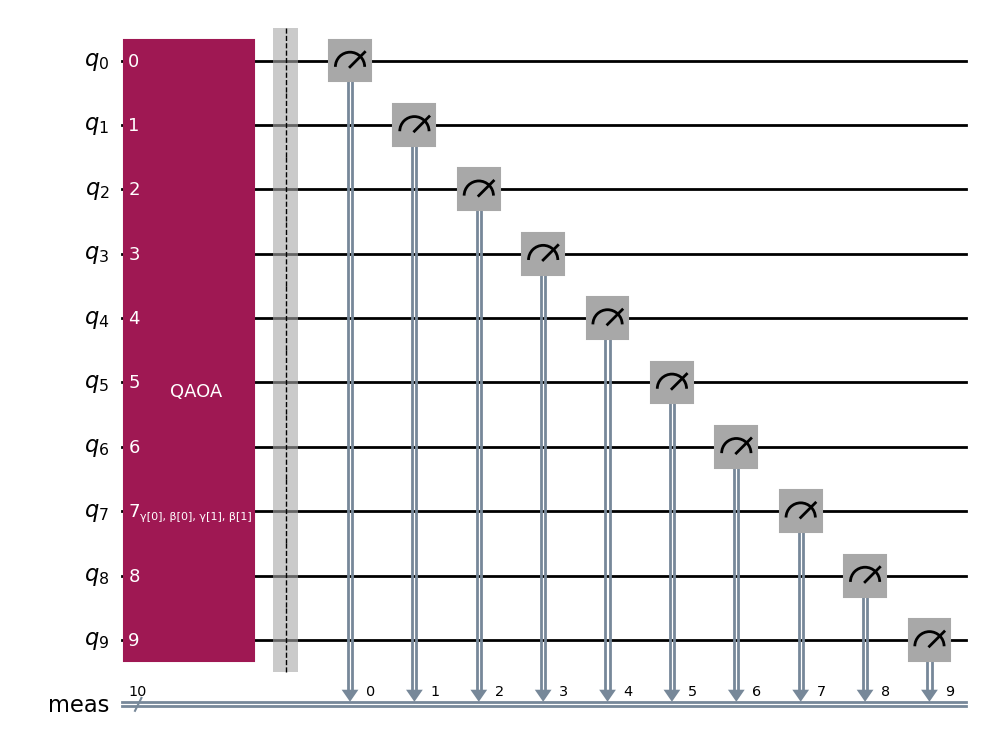

In [50]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [51]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### Step 2. Optimize circuits for quantum hardware execution


The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run on the hardware. To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. You need to make sure that your circuit is **optimized** for your purpose.

Transpilation may involves several steps, such as:

* **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device.
* **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
* **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
* **Error suppression** by adding single-qubit gates to suppress noise with dynamical decoupling.

More information about transpilation is available in our [documentation](https://docs.quantum.ibm.com/transpile).

The following code transforms and optimizes the abstract circuit into a format that is ready for execution on one of devices accessible through the cloud using the **Qiskit IBM Runtime service**.


<IBMBackend('ibm_sherbrooke')>


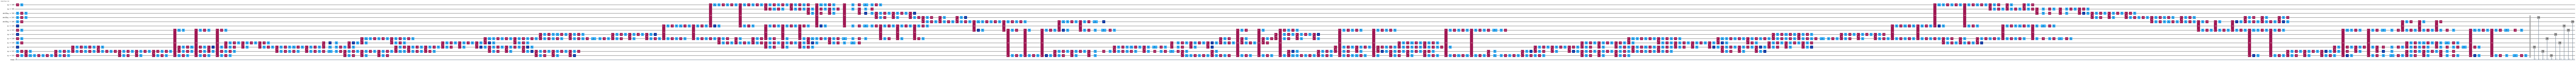

In [53]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


QiskitRuntimeService.save_account(channel="ibm_quantum", token="34fe07dd270ffcb9c02fe16bd7eb37080a5109321d814e71eb6cc263ec8e8320ae021df5dc6cbf569e5747224c8dc0b0bf121fd1e3cdb233693518c8b8d1bf88", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

### Step 3. Execute using Qiskit primitives


In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. This execution loop is executed via the following steps:

1. Define the initial parameters
2. Instantiate a new `Session` containing the optimization loop and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.


#### Define circuit with initial parameters

We start with arbitrary chosen parameters.


In [54]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

#### Define backend and execution primitive

Use the **Qiskit Runtime primitives** to interact with IBM® backends. The two primitives are Sampler and Estimator, and the choice of primitive depends on what type of measurement you want to run on the quantum computer. For the minimization of $H_c$, use the Estimator since the measurement of the cost function is simply the expectation value of $\langle H_c \rangle$.


#### Run

The primitives offer a variety of [execution modes](https://docs.quantum.ibm.com/run/execution-modes) to schedule workloads on quantum devices, and a QAOA workflow runs iteratively in a session.

![Illustration showing the behavior of Single job, Batch, and Session runtime modes.](https://learning-api.quantum.ibm.com/assets/73e400b1-e5a9-4ee8-9842-3e2bbfbef3f5)

You can plug the sampler-based cost function into the SciPy minimizing routine to find the optimal parameters.


In [55]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [56]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize
from time import time

print(time())
objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)
print(time())

1736542329.0578258


RuntimeJobFailureError: 'Unable to retrieve job result. Error code 1500; Internal error. -- Try again or contact support. -- https://ibm.biz/error_codes#1500'

The optimizer was able to reduce the cost and find better parameters for the circuit.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once you have found the optimal parameters for the circuit, you can assign these parameters and sample the final distribution obtained with the optimized parameters. Here is where the *Sampler* primitive should be used since it is the probability distribution of bitstring measurements which correspond to the optimal cut of the graph.

**Note:** This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state - for example, `010101110000...` - which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).


In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

### Step 4. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for your original problem. In this case, you are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that four of the bitstrings are distictively more likely than the rest.


In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

NameError: name 'final_distribution_int' is not defined

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

NameError: name 'final_distribution_bin' is not defined

#### Visualize best cut

From the optimal bit string, you can then visualize this cut on the original graph.


In [ ]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

And calculate the value of the cut


In [ ]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

## Part 2: scale it up!

You have access to many devices with over 100 qubits on IBM Quantum Platform. Select one on which to solve Max-Cut on a 100-node weighted graph. This is a "utility-scale" problem. The steps to build the workflow are followed the same as above, but with a much larger graph.


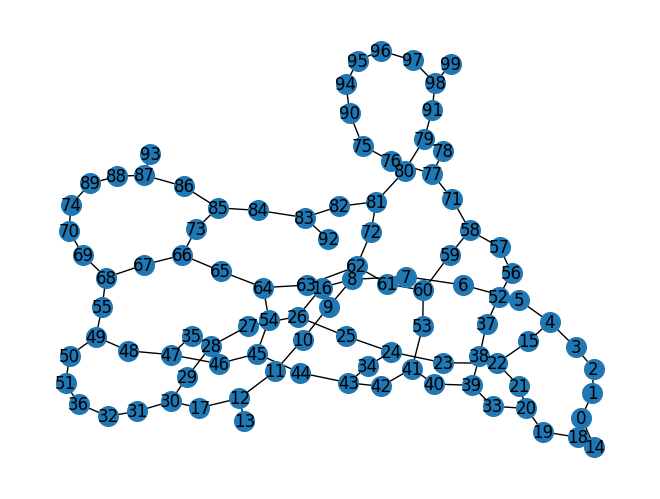

In [ ]:
n = 100  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

In [ ]:
%%time
graphnx = rustworkx_to_networkx(graph_100)
BMSolver = MaxCutBM(graphnx)
print("BM Solver result:", BMSolver.solve())

maximum number of iterations reached
6 candidate solutions reached after 9999 iterations.

Solved the BM-formulated max-cut problem.
Solution cuts off 0.919643 share of total weights.
BM Solver result: None
CPU times: user 47.1 s, sys: 35.6 s, total: 1min 22s
Wall time: 48 s


In [ ]:
%%time
graphnx = rustworkx_to_networkx(graph_100)
SDPsolver = MaxCutSDP(graphnx)
print("SDP Solver result:", SDPsolver.solve())

Solved the SDP-relaxed max-cut problem.
Solution cuts off 1.000000 share of total weights.
SDP Solver result: None
CPU times: user 3.44 s, sys: 11.4 ms, total: 3.45 s
Wall time: 3.45 s


### Step 1. Map classical inputs to a quantum problem


#### Graph → Hamiltonian

First, convert the graph you want to solve directly into a Hamiltonian that is suited for QAOA.


In [ ]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

#### Hamiltonian → quantum circuit


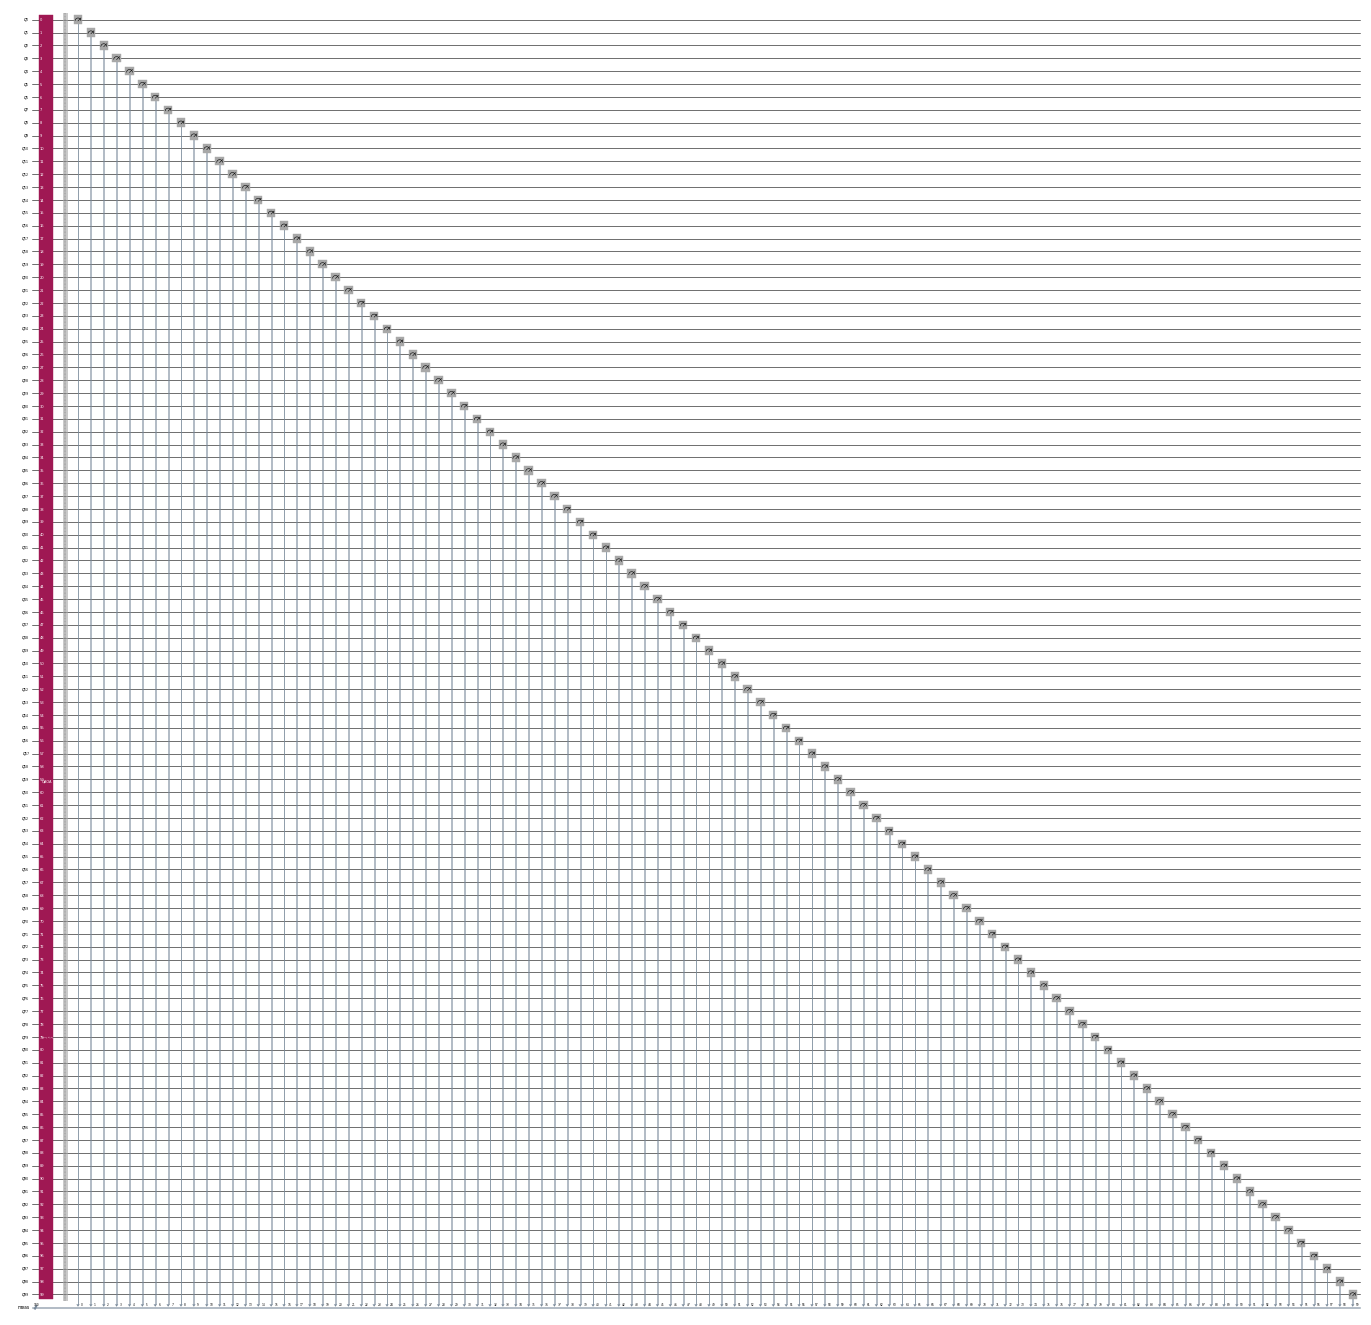

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

### Step 2. Optimize problem for quantum execution

To scale the circuit optimization step to utility-scale problems, you can take advantage of the high performance transpilation strategies introduced in Qiskit SDK v1.0. Other tools include the new transpiler service with [AI enhanced transpiler passes](https://docs.quantum.ibm.com/transpile/ai-transpiler-passes).


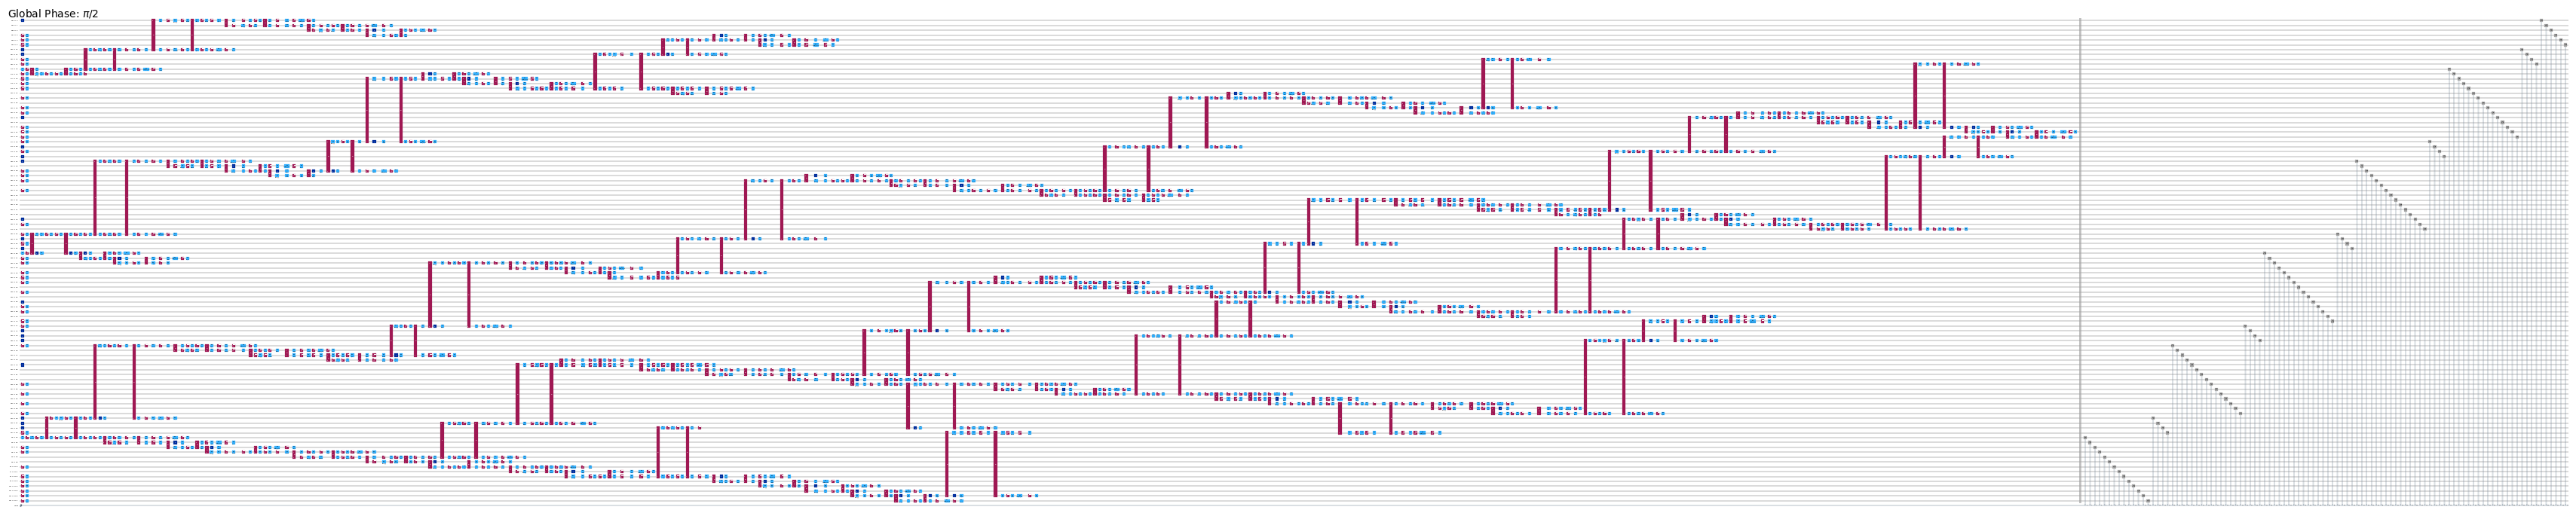

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1, idle_wires=False)

### Step 3. Execute using Qiskit primitives

To run QAOA, you must know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. Optimize these parameters by running an optimization loop on the device. The cell submits jobs until the cost function value has converged and the optimal parameters for $\gamma_k$ and $\beta_k$ are determined.


#### Find candidate solution by running the optimization on the device


First, run the optimization loop for the circuit parameters on a device.


In [ ]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

print(time())

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA",
    )
    print(result)
print(time)

1733772519.4268796


RuntimeJobFailureError: 'Unable to retrieve job result. Error code 1500; Internal error. -- Try again or contact support. -- https://ibm.biz/error_codes#1500'

Once the optimal parameters from running QAOA on the device have been found, assign the parameters to the circuit


In [ ]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw('mpl', fold=False, idle_wires=False)

Finally, execute the circuit with the optimal parameters to sample from the corresponding distribution.


In [ ]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"


pub= (optimized_circuit_100, )
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {key: val/shots for key, val in counts_int.items()}

### Step 4. Post-process, return result in classical format


Check that the cost minimized in the optimization loop has converged to a certain value. The code below uses the parameters corresponding to the minimum value of the cost.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Given that the likelihood of each solution is low, extract the solution that corresponds to the lowest cost.


In [ ]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol

    return min_sol

best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()

print("Result bitstring:", best_sol_bitstring_100)

Next, visualize the cut. Nodes of the same color belong to the same group.


In [ ]:
plot_result(graph_100, best_sol_bitstring_100)

And calculate the the value of the cut


In [ ]:
cut_value_100= evaluate_sample(best_sol_bitstring_100, graph_100)
print('The value of the cut is:', cut_value_100)

Now you need to compute the objective value of each sample that you measured on the quantum computer. The sample with the lowest objective value is the solution returned by the quantum computer.


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)


def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1",)
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)

# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

In [ ]:
result_dist = samples_to_objective_values(final_distribution_100_int, cost_hamiltonian_100)

Finally, you can plot the cumulative distribution function to visualize how each sample contributes to the total probability distribution and the corresponding objective value. The horizontal spread shows the range of objective values of the samples in the final distribution. Ideally, you would see that the cumulative distribution function has "jumps" at the lower end of the objective function value axis. This would mean that few solutions with low cost have high probability of being sampled. A smooth, wide curve indicates that each sample is similarly likely, and they can have very different objective values, low or high.


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Eagle device")

## Conclusion

This tutorial demonstrated how to solve an optimization problem with a quantum computer using the Qiskit patterns framework. The demonstration included a utility-scale example, with circuit sizes that cannot be exactly simulated classically. Currently, quantum computers do not outperform classical computers for combinatorial optimization because of noise. However, the hardware is steadily improving, and new algorithms for quantum computers are continually being developed. Indeed, much of the research working on quantum heuristics for combinatorial optimization is tested with classical simulations that only allow for a small number of qubits, typically around 20 qubits. Now, with larger qubit counts and devices with less noise, researchers will be able to start benchmarking these quantum heuristics at large problem sizes on quantum hardware.
